In [3]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


def load_data(path):
    data = pd.read_csv(path).drop(['Age', 'Gender', 'Snoring', 'Swallowing Difficulty'], axis=1)
    data['Level'] = data['Level'].map({'Normal': 0, 'Benign': 1, 'Malignant': 2})

    sampler = RandomOverSampler(random_state=4)
    X, y = sampler.fit_resample(data.drop('Level', axis=1), data['Level'])

    return train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)

In [17]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


import json
import pandas as pd
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from joblib import load, dump
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [18]:
X_train, _, y_train, _ = load_data('../data/small_data.csv')
seed = list(range(0, 10))

# (enabled, name, cls, param_grid)
tuning_specs = [
    (1, 'ada', AdaBoostClassifier, {
        'n_estimators': [i * 50 for i in range(1, 5)],
        'learning_rate': [i * 0.05 for i in range(1, 11)],
        'algorithm': ['SAMME'],
        'random_state': seed
    }),
    (1, 'gbc', GradientBoostingClassifier, {
        'learning_rate': [i * 0.05 for i in range(1, 11)],
        'n_estimators': [i * 50 for i in range(1, 5)],
        'max_depth': [i * 5 for i in range(1, 4)],
        'random_state': seed
    }),
    (1, 'rfc', RandomForestClassifier, {
        'n_estimators': [i * 100 for i in range(1, 11)],
        'max_depth': [i * 5 for i in range(1, 4)],
        'min_samples_split': [i * 2 for i in range(1, 6)],
        'min_samples_leaf': [i * 2 for i in range(1, 6)],
        'random_state': seed
    }),
    (1, 'log', LogisticRegression, {
        'C': [10 ** i for i in range(-3, 4)],
        'max_iter': [i * 500 for i in range(1, 6)],
        'random_state': seed
    }),
    (1, 'knn', KNeighborsClassifier, {
        'n_neighbors': [i * 2 for i in range(2, 11)],
        'weights': ['uniform', 'distance'],
        'leaf_size': [i * 10 for i in range(1, 11)]
    }),
    (1, 'mlp', MLPClassifier, {
        'hidden_layer_sizes': [(i * 10,) for i in range(1, 5)],
        'alpha': [10 ** i for i in range(-4, 0)],
        'learning_rate_init': [10 ** i for i in range(-4, 0)],
        'batch_size': [i * 100 for i in range(1, 11)],
        'max_iter': [i * 500 for i in range(6, 11)],
        'random_state': seed
    }),
    (1, 'svc', SVC, {
        'C': [10 ** i for i in range(-3, 4)],
        'gamma': [10 ** i for i in range(-3, 4)],
        'class_weight': [None, 'balanced'],
        'random_state': seed
    })
]

with open('../models/tuned_hyperparams.json', 'r') as f:
    tuned_hyperparams = json.load(f)

for enabled, name, cls, param_grid in tuning_specs:
    if enabled:
        print(name.upper(), '-' * 80)

        model = HalvingGridSearchCV(cls(), param_grid, n_jobs=2, verbose=1)
        model.fit(X_train, y_train)

        tuned_hyperparams[name] = model.best_params_

        print()

with open('../models/tuned_hyperparams.json', 'w') as f:
    json.dump(tuned_hyperparams, f)

ADA --------------------------------------------------------------------------------
n_iterations: 3
n_required_iterations: 6
n_possible_iterations: 3
min_resources_: 30
max_resources_: 664
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 400
n_resources: 30
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
----------
iter: 1
n_candidates: 134
n_resources: 90
Fitting 5 folds for each of 134 candidates, totalling 670 fits
----------
iter: 2
n_candidates: 45
n_resources: 270
Fitting 5 folds for each of 45 candidates, totalling 225 fits

GBC --------------------------------------------------------------------------------
n_iterations: 3
n_required_iterations: 7
n_possible_iterations: 3
min_resources_: 30
max_resources_: 664
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1200
n_resources: 30
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
----------
iter: 1
n_candidates: 400
n_resources: 90
Fitting 5 folds for

In [19]:
X_train, X_test, y_train, y_test = load_data('../data/big_data.csv')

# (train/~load, save, load, name, cls)
model_specs = [
    (1, 1, 'ada', AdaBoostClassifier),
    (1, 1, 'gbc', GradientBoostingClassifier),
    (1, 1, 'rfc', RandomForestClassifier),
    (1, 1, 'log', LogisticRegression),
    (1, 1, 'knn', KNeighborsClassifier),
    (1, 1, 'mlp', MLPClassifier),
    (1, 1, 'svc', SVC),
]

with open('../models/tuned_hyperparams.json', 'r') as f:
    tuned_hyperparams = json.load(f)

model_names = []
f1 = []
accuracy = []
precision = []
recall = []

for train, save, name, cls in model_specs:
    model_names.append(name)
    model = None

    if train:
        model = cls(**tuned_hyperparams[name])
        model.fit(X_train, y_train)

        if save:
            with open(f'../models/{name}.pkl', 'wb') as f:
                dump(model, f)
    else:
        with open(f'../models/{name}.pkl', 'rb') as f:
            model = load(f)
    
    y_pred = model.predict(X_test)
    f1.append(f1_score(y_test, y_pred, average='macro'))
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred, average='macro'))
    recall.append(recall_score(y_test, y_pred, average='macro'))

    print(name.upper(), '-' * 5, f'{f1[-1]:.2f} {accuracy[-1]:.2f} {precision[-1]:.2f} {recall[-1]:.2f}')

pd.DataFrame({
    'Name': model_names,
    'F1': f1,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall
}).to_csv('../models/performance.csv', index=False)

ADA ----- 0.84 0.84 0.84 0.84
GBC ----- 0.87 0.87 0.87 0.87
RFC ----- 0.87 0.87 0.87 0.87
LOG ----- 0.81 0.81 0.81 0.81
KNN ----- 0.86 0.86 0.86 0.86
MLP ----- 0.83 0.83 0.83 0.83
SVC ----- 0.85 0.85 0.85 0.85


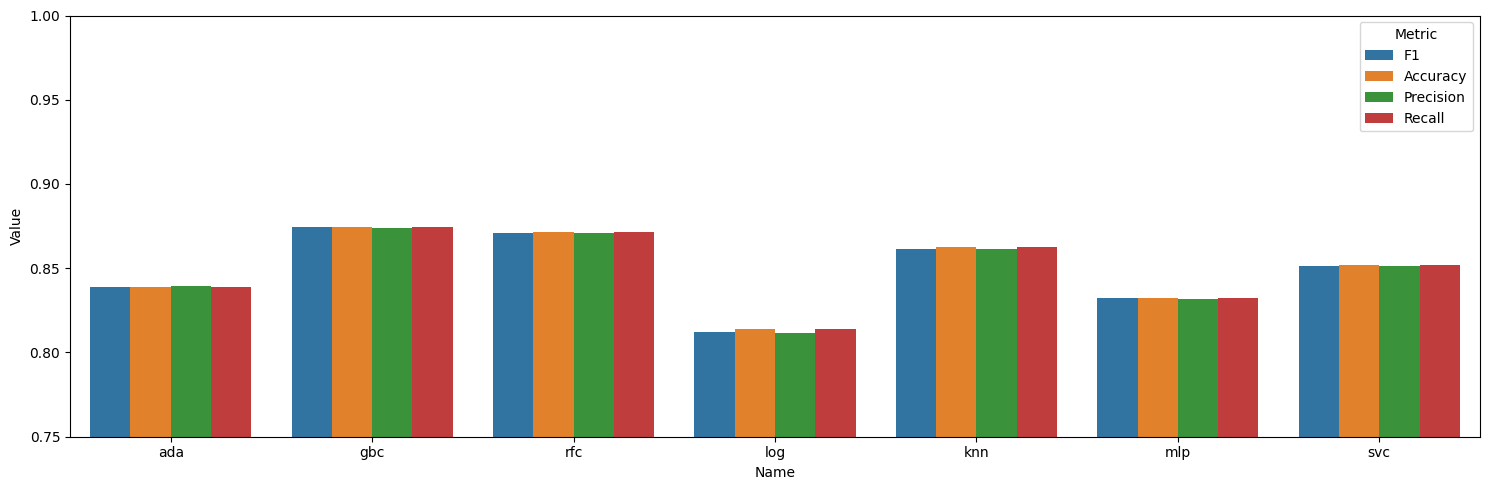

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
plt.ylim(bottom=0.75)
sns.barplot(
    data = pd.read_csv('../models/performance.csv').melt(id_vars='Name', var_name='Metric', value_name='Value'),
    x = 'Name', y = 'Value', hue = 'Metric'
)

plt.tight_layout()
plt.show()